# 0. Importing Libraries

https://www.kaggle.com/code/brendanartley/nih-chest-x-rays-eda
https://www.kaggle.com/code/rahulogoel/chest-x-rays-eda-clahe-enchanced-balanced#Code

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import cv2
import os
import glob
from itertools import chain

from skimage import io
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx

#probably best to not ignore warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_theme()
from sklearn.preprocessing import MultiLabelBinarizer


# 1. Exploring dataset

## 1.1 Loading Data Files

In [ ]:
df = pd.read_csv('../input/data/Data_Entry_2017.csv')
df = df[df['Patient Age'] <= 120] # remove if age > 120
df.head()

## 1.2 Descriptive statistics

**Interesting Notes**

* The dataset resizes all images to 1024 x 1024 but the original image dimensions are stored in the data frame. These dimensions are not consistent across all images.

* Is there a patient who is 414 years old, or is the Patient Age column using a different scale than years?

* The highest follow-up number is 183. Does this mean one patient has 183 images in the dataset?

In [ ]:
print("Rows: ", len(df))
print("Unique Image files: ", df["Image Index"].nunique())
print("Unique Patients: ", df["Patient ID"].nunique())

#descriptive stats
df.describe()

## 1.3 Check Null Values

In [ ]:
df.info()

# drop Unnamed
df.drop("Unnamed: 11", axis=1, inplace=True)

# 2. Exploring Dataset Columns

## 2.1 Image Index

The image names are in the following format `00000001_000.png`. The number before the underscore corresponds to the `Patient ID`, and the number after the underscore is the image number (dependant on `Patient ID`).

**Interesting Notes**

* All the images are stored as PNG images. Since PNG images are higher quality than that JPEG images they take up more storage. This must be kept in mind when developing a model pipeline.

In [ ]:
print(df["Image Index"][0:5])

## 2.2 Finding Labels

The finding labels will be used as the true `labels` when training a model. These are essentially the diagnoses given by a doctor. 

There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

- Atelectasis
- Consolidation
- Infiltration
- Pneumothorax
- Edema
- Emphysema
- Fibrosis
- Effusion
- Pneumonia
- Pleural_thickening
- Cardiomegaly
- Nodule Mass
- Hernia

**Interesting Notes**

- If the labels are split and ordered alpha-numerically the number of unique pairs changes. ie `Pneumonia|Effusion` should be marked the same as `Effusion|Pneumonia`. This decreases the number of unique labels by ~30.

- ~1600 images have 4+ labels, is this an error? How should these data points be handled? 

In [ ]:
print("Unique Combinations Before Transform: ", df["Finding Labels"].nunique())

df["Finding Labels"] = df["Finding Labels"].str.split("|").apply(lambda x: sorted(x)).str.join("|")

print("Actual Unique Combinations: ", df["Finding Labels"].nunique())

In the following plot, the images that have multiple labels are split into their own rows and the raw label count is shown. The majority of the images have `No Finding`, followed by `Effusion`, `Infiltration`, and `Atelectasis`.

The least common label type is a `Hernia`.

In [ ]:
def finding_Labels_p1(df):
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')["var1"]
    test = test.reset_index(drop=True).to_frame()
    test.columns = ["label"]

    fig, ax = plt.subplots(figsize=(15,5))
    ax.tick_params(axis='x', rotation=45)
    sns.histplot(test, x="label", discrete=True, ax=ax, shrink=.9).set_title("Label Values")
    ax.bar_label(ax.containers[0])
    plt.ylim(0,70000)
    plt.show(sns)

finding_Labels_p1(df)

The next hist plot shows the number of labels associated with each image. The vast majority of the x-ray images contain 4 or fewer labels yet some images contain more.

The longest label attached to an image is:

`Atelectasis|Consolidation|Effusion|Fibrosis|Infiltration|Mass|Nodule|Pleural_Thickening|Pneumothorax`

In [ ]:
def finding_Labels_p2(df):
    
    test = df["Finding Labels"].str.count(r'\|') + 1
    test = test.reset_index(drop=True).to_frame()
    test.columns = ["Label Count"]

    fig, ax = plt.subplots(figsize=(15,5))
    sns.histplot(test, x="Label Count", discrete=True, ax=ax, shrink=.9).set_title("Number of Labels Per Image")
    ax.bar_label(ax.containers[0])
    plt.ylim(0,100000)
    plt.show(sns)
    
finding_Labels_p2(df)

## 2.3 Follow-up Number

The follow-up number is an indicator as to how many times a patient is seen.

As expected the plot is heavily right-skewed and most patients have fewer than 10 images in the dataset. That being said there are some extraneous outliers such as the patient with 183 images in the dataset as mentioned earlier.

In [ ]:
def follow_up_number_p1(df):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.histplot(data=df, x="Follow-up #", ax=ax).set_title('Number of Images by Patient')
    plt.xlim(0,60)
    plt.show(sns)

follow_up_number_p1(df)

## 2.4 Patient ID


## 2.5 Patient Age

There are a few errors/mislabelled points in the patient age column, with one patient being 414 years old. Any records with a patient age above 120 are removed from the dataset in the plot.

- In the following plot the majority of patients are between 30-70 years old. That being said there is a nice variety of patient ages in the dataset.

- There are also three groups with a large number of samples relative to their neighbors. Was this a result of the data collection strategy, or are there routine checks done at these ages?

In [ ]:
def patient_age_p1(df):
    test = df[df['Patient Age'] <= 120]
    test = df.groupby("Patient ID").agg('first')

    fig, ax = plt.subplots(figsize=(15,5))
    sns.histplot(test, x="Patient Age", ax=ax, bins=90)
    plt.show(sns)

patient_age_p1(df)

## 2.6 Patient Gender


There are slightly more images of Male patients than Female patients in the dataset, yet this is quite a small difference.

In [ ]:
def patient_gender_p1(df):
    #remove duplicate patients
    test = df.groupby("Patient ID").agg('first')

    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(test, x="Patient Gender", discrete=True, ax=ax, shrink=.9).set_title("Number of Images by Gender")
    ax.bar_label(ax.containers[0])
    plt.ylim(0,20000)
    plt.show(sns)
    
patient_gender_p1(df)

## 2.7 View Position

This variable provides us with the "View" at which the image was taken. The two possible values in this column are `PA` or `AP`.

`PA` - From the back (Posterior to Anterior)

`AP` - From the front (Anterior to Posterior)

In [ ]:
def view_position_p1(df):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(df, y='View Position', discrete=True, ax=ax, shrink=.9).set_title("Number of Images by Position")
    ax.bar_label(ax.containers[0])
    plt.xlim(0, 80000)
    plt.show(sns)
    
view_position_p1(df)

## 2.8 OriginalImageWidth, OriginalImageHeight, OriginalImagePixelSpacing

The remaining columns OriginalImageWidth, OriginalImageHeight, and OriginalImagePixelSpacing provide information on the orginal image dimensions.

For now, these columns will be removed.

In [ ]:
cols_of_interest = ["Image Index", "Finding Labels", "Follow-up #",
                   "Patient ID", "Patient Age", "Patient Gender",
                   "View Position"]

df = df[cols_of_interest]
df.head(5)

# 3. Relationship Between Variables

- How does the distribution of Age change by Gender?
- Are patients more likely to be diagnosed with a certain label in later follow-ups?
- etc.


## 3.1 Distribution of Age by Gender?

Similar to the plot shown in section 2.5, the following plot shows that there are some outlying age groups. What is different is that these outlying groups differ by gender.

In [ ]:
def age_by_gender_p1(df):
    test = df.groupby("Patient ID").agg('first')
    fig, axes = plt.subplots(2,1,figsize=(20,10))

    for i, val in enumerate(["M","F"]):
        test1 = test[test['Patient Gender'] == val].reset_index()
        sns.histplot(test1, x="Patient Age", ax=axes[i], bins=90)

    plt.show(sns)
    
age_by_gender_p1(df)

## 3.2 Distribution of Finding Labels by Gender?


The Cardiomegaly label is the only label in which more images are of female patients.

In [ ]:
def labels_by_gender_p1(df):
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
    plot_df = pd.DataFrame()

    for val in ["M", "F"]:
        test1 = test[test["Patient Gender"] == val].reset_index(drop=True)
        test1 = test1.groupby("var1").size().sort_index().reset_index(name="count")
        test1["Patient Gender"] = val

        plot_df = pd.concat([plot_df, test1]).reset_index(drop=True)

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Gender")
    ax = sns.barplot(y="var1", hue="Patient Gender", x="count", data=plot_df, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)

labels_by_gender_p1(df)

## 3.3 Distribution of Finding Labels by Age?

There is some significant difference between the relative percentage of finding labels across the age groups. In the following cell, the percentage of finding labels within each group is plotted.

- The plot suggests that Patients under 29 years old are more likely to have `Pneumothorax`, `Infiltration` or `No Finding` than the rest of the population.

- Patients older than 69 years old are more likely to have `Pleural_Thickening`, `Fibrosis`, `Hernia`, `Emphysema`, `Effusion`, `Cardiomegaly`, and `Atelectasis` than other age groups. This high relative percentage could be because older patients are the least likely to have no findings on their X-rays.

- Patients in the 30 - 49 age group are consistently in the middle of the pack, yet fall a close second in the `Edema` and `Cardiomegaly` categories.

- Finally, patients in the 50 - 69 age group are more likely than other age groups to have the finding labels `Nodule` and `Mass`.

In [ ]:
def labels_by_age_p1(df):
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

    conditions = [
        (test['Patient Age'] <= 29),
        (test['Patient Age'] >= 30) & (test['Patient Age'] <= 49),
        (test['Patient Age'] >= 50) & (test['Patient Age'] <= 69),
        (test['Patient Age'] >= 60)
    ]

    choices = ['29 and Under', '30 - 49', '50 - 69', '69+']
    test['age_bracket'] = np.select(conditions, choices, default=np.nan)
    test1 = test.groupby(["age_bracket", "var1"]).size().sort_index().reset_index(name="count")
    test2 = test1.groupby("age_bracket").sum("count").reset_index()

    test1 = test1.merge(test2, on='age_bracket', suffixes=('', '_total'))
    test1["percentage"] = test1["count"]/test1["count_total"]

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Age Bracket")
    ax = sns.barplot(y="var1", hue="age_bracket", x="percentage", data=test1, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)
    
labels_by_age_p1(df)

## 3.4 Distribution of Finding Labels by Follow-up Number?

In the following plot. The more visits a patient makes (ie. the greater the follow-up #), the more likely it is that the finding labels are not labeled with `No Finding`.

- Some of the finding labels that are diagnoses with a higher proportion in later visits are `Cardiomegaly`, `Consolidation`, `Edema`, `Effusion`, `Infiltration`, `Pleural_Thickening`, `Pneumonia`, and `Pneumothorax`. 

- Interestingly, the `Nodule` label is more likely to be classified in earlier visits. Maybe this label is easier to classify than others?

In [ ]:
def labels_by_follow_up_p1(df):
    
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

    conditions = [
        (test['Follow-up #'] <= 1),
        (test['Follow-up #'] >= 2) & (test['Follow-up #'] <= 4),
        (test['Follow-up #'] >= 5) & (test['Follow-up #'] <= 7),
        (test['Follow-up #'] >= 8)
    ]

    choices = ['1st Visit', '2 - 4', '5 - 7', '8+']
    test['Appointment #'] = np.select(conditions, choices, default=np.nan)
    test1 = test.groupby(["Appointment #", "var1"]).size().sort_index().reset_index(name="count")
    test2 = test1.groupby("Appointment #").sum("count").reset_index()

    test1 = test1.merge(test2, on='Appointment #', suffixes=('', '_total'))
    test1["percentage"] = test1["count"]/test1["count_total"]

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Visit #")
    ax = sns.barplot(y="var1", hue="Appointment #", x="percentage", data=test1, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)
    
labels_by_follow_up_p1(df)

## 3.5 Labels With More Than One Disease?

In the following cell, single vs multi-label diagnoses are evaluated. Since "No Finding" is mutually exclusive this label option is removed.

- Interestingly, once "No Finding" is removed, every label is found more often as in a multi-label classification. This is more pronounced with the `Atelectasis` and `Effusion` labels. That being said, the `Infiltration` and `Hernia` labels are close to a 50/50 split.

In [ ]:
def single_multiple_diseases_p1(df):
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
    test["multiple_diseases"] = test['Finding Labels'].str.match(r'\w+\|\w+') #counting "|" occurances
    test = test[test["Finding Labels"]!="No Finding"]
    test1 = test.groupby(["var1", "multiple_diseases"]).size().sort_index().reset_index(name="count")

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Gender")
    ax = sns.barplot(y="var1", hue="multiple_diseases", x="count", data=test1, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)
    
single_multiple_diseases_p1(df)

## 3.6 Labels Found Together?

Some labels are going to be found more often together than others. The following section is looking solely at the possible combinations of **two labels**.

- As shown in the plot below, all possible label combinations are found in the dataset. This is an interesting finding in itself but does not reveal anything about the relative frequency of each relationship.

In [ ]:
def label_groups_p1(df):
    #preprocessing data
    df = df[df["Finding Labels"].str.count(r'\|') == 1]
    df["tags"] = df["Finding Labels"].str.split("|")
    df["tags"] = df["tags"].apply(lambda x: sorted(x))

    #getting unique labels
    all_tags = np.unique(np.concatenate(df['tags'].values))
    all_tags

    #add edge helper
    def add_edge_weight(head, tail):
        try:
            weight = G[head][tail]['weight']
        except:
            G.add_edge(head, tail, weight=1)
        else:
            G[head][tail]['weight'] += 1

    # initialize graph
    G = nx.Graph()

    # add all nodes (tags)
    for t in all_tags:
        G.add_node(t)

    # add all edges (tags occurring together)
    for q in df.index:
        tags = df.loc[q, 'tags']
        for i in range(len(tags)-1):
            for j in range(i+1, len(tags)):
                add_edge_weight(tags[i], tags[j])

    plt.figure(figsize=(15,15))
    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='tab:red')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=0.2)
    nx.draw_networkx_labels(G, pos, {n: str(n) for n in list(G.nodes())}, font_weight='bold', font_color='k')
    plt.show()
    
label_groups_p1(df)

To explore the relative frequency of each relationship, another Networkx graph is created with the width of the edges in proportion to the number of occurrences in the data.

- This graph reveals that the most frequent pairings are between `Infiltration` - `Atelectasis`, `Infiltration` - `Effusion` and `Atelectasis` - `Effusion`.

- In the previous sub-section it was shown that these three labels were likely to be found with other labels. This could explain their relatively high frequency in this plot.

In [ ]:
def label_groups_p2(df):
    #preprocessing data
    df = df[df["Finding Labels"].str.count(r'\|') == 1]
    df["tags"] = df["Finding Labels"].str.split("|")
    df["tags"] = df["tags"].apply(lambda x: sorted(x))

    #getting unique labels
    all_tags = np.unique(np.concatenate(df['tags'].values))
    all_tags

    #add edge helper
    def add_edge_weight(head, tail):
        try:
            weight = G[head][tail]['weight']
        except:
            G.add_edge(head, tail, weight=1)
        else:
            G[head][tail]['weight'] += 1

    # initialize graph
    G = nx.Graph()

    # add all nodes (tags)
    for t in all_tags:
        G.add_node(t)

    # add all edges (tags occurring together)
    for q in df.index:
        tags = df.loc[q, 'tags']
        for i in range(len(tags)-1):
            for j in range(i+1, len(tags)):
                add_edge_weight(tags[i], tags[j])

    plt.figure(figsize=(15,15))
    pos = nx.shell_layout(G)

    #calc total weights
    w_sum = 0
    for (node1,node2,data) in G.edges(data=True):
        w_sum += data['weight']

    #draw edges + nodes
    for (node1,node2,data) in G.edges(data=True):
        width = data["weight"]*len(G.nodes)*10.0/w_sum
        nx.draw_networkx_edges(G,pos,edgelist=[(node1, node2)],width=width)

    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='tab:red')

    #draw labels w/ out overlap
    new_pos = {k: np.asarray([v[0]*1.2, v[1]*1.15]) for k, v in pos.items()}
    nx.draw_networkx_labels(G, new_pos, {n: str(n) for n in list(G.nodes())})
    plt.margins(x=0.15, y=0.15)
    plt.show()
    
label_groups_p2(df)

# 4. Preprocessing

## 4.1 One Hot Encoding

In [ ]:
labels = df["Finding Labels"].unique()
n_labels = [x.split('|') for x in list(df["Finding Labels"])]

multilabel_binarizer = MultiLabelBinarizer()
y = multilabel_binarizer.fit_transform(n_labels)

extract_labels = list(multilabel_binarizer.classes_)
extract_labels

In [ ]:
n_df = pd.DataFrame(y)
n_df = n_df.set_axis(extract_labels, axis = 1)
# n_df.drop("No Finding",axis=1 ,inplace= True)
n_df.insert(0,"Path", value=df["Image Index"])
n_df.head()

In [ ]:
n_df.to_csv("labels.csv", index = False)

In [ ]:
df_WO_NoFindings = n_df.drop(columns =["No Finding"])

plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(df_WO_NoFindings.iloc[:, 1:].corr(), annot=True, fmt=".2f")
plt.tight_layout()
plt.show()

In [ ]:
# import pandas as pd
# import numpy as np
# from skimage.io import imread
# from skimage.transform import resize
# from sklearn.feature_selection import mutual_info_classif, SelectKBest
# from sklearn.model_selection import train_test_split

# # Load the label table
# labels_df = pd.read_csv('/kaggle/input/nih-balanced-and-resized-chest-x-rays/new_labels.csv')  # Columns: Path, Atelectasis, Cardiomegaly, etc.

# # Define image directory and grid size
# image_dir = '/kaggle/input/nih-balanced-and-resized-chest-x-rays/resized_images/resized_images/'
# grid_size = 16  # 16x16 grid for 256x256 images

# # Take a 10% sample of the data
# sample_size = 0.1  # 5,100 images
# labels_sample, _ = train_test_split(labels_df, test_size=1 - sample_size, random_state=42)

# # Function to extract grid features (mean intensity per cell)
# def extract_grid_features(image_path):
#     image = imread(image_dir + image_path, as_gray=True)
#     if image.shape != (256, 256):  # Resize if needed
#         image = resize(image, (256, 256))
#     cell_size = 256 // grid_size  # 16 pixels per cell
#     features = []
#     for i in range(grid_size):
#         for j in range(grid_size):
#             cell = image[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
#             features.append(np.mean(cell))
#     return np.array(features)

# # Extract features for the sample
# X_sample = np.array([extract_grid_features(path) for path in labels_sample['Path']])

# # List of disease labels
# disease_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
#                    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 
#                    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']  # Add all your labels here
# Y_sample = labels_sample[disease_columns].values

# # Select the top 10 features per disease from the sample
# k = 10
# selected_features = set()
# for d in range(Y_sample.shape[1]):
#     disease_label = Y_sample[:, d]
#     selector = SelectKBest(mutual_info_classif, k=k)
#     selector.fit(X_sample, disease_label)
#     selected_indices = selector.get_support(indices=True)
#     selected_features.update(selected_indices)

# # Function to extract only the selected features
# def extract_selected_features(image_path, selected_indices):
#     image = imread(image_dir + image_path, as_gray=True)
#     if image.shape != (256, 256):
#         image = resize(image, (256, 256))
#     cell_size = 256 // grid_size
#     features = []
#     for idx in selected_indices:
#         i, j = divmod(idx, grid_size)
#         cell = image[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
#         features.append(np.mean(cell))
#     return np.array(features)

# # Extract selected features for all 51,000 images
# X_full_selected = np.array([extract_selected_features(path, list(selected_features)) 
#                             for path in labels_df['Path']])

# print(f"Selected {len(selected_features)} features out of 256 for the full dataset.")

In [ ]:
# selected_features

In [ ]:
# # Function to convert index to (row, column)
# def index_to_grid(index, grid_size=16):
#     row = index // grid_size
#     column = index % grid_size
#     return row, column

# # Map selected indices to (row, column)
# selected_grid_positions = {index: index_to_grid(index) for index in selected_features}

# # Print a few examples
# for idx, (row, col) in list(selected_grid_positions.items())[:5]:
#     print(f"Index {idx}: Row {row}, Column {col}")

In [ ]:
# import matplotlib.pyplot as plt
# from skimage.io import imread
# from skimage.transform import resize

# # Load a sample image (replace 'sample_image.png' with your image path)
# sample_image = imread('/kaggle/input/nih-balanced-and-resized-chest-x-rays/resized_images/resized_images/00000001_000.png', as_gray=True)
# if sample_image.shape != (256, 256):
#     sample_image = resize(sample_image, (256, 256))  # Resize to match grid assumption

# # Plot the image
# plt.imshow(sample_image, cmap='gray')
# plt.axis('off')

# # Overlay selected grid cells
# cell_size = 256 // 16  # Each cell is 16x16 pixels if image is 256x256
# for index in selected_features:
#     row, col = index_to_grid(index)
#     plt.gca().add_patch(plt.Rectangle((col * cell_size, row * cell_size), cell_size, cell_size, 
#                                       edgecolor='red', facecolor='none', linewidth=1))

# plt.title("Selected Features on Chest X-Ray")
# plt.show()

In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

# Load the labels from a CSV file
labels_df = pd.read_csv('/kaggle/input/nih-balanced-and-resized-chest-x-rays/new_labels.csv')

# Sample 5,100 images (10% of 51,000) while preserving balance
# Assuming the dataset is balanced, use random sampling
sampled_df = labels_df.sample(n=5100, random_state=42)

# Define the list of disease labels
disease_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
                   'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 
                   'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Split data into train (70%), validation (10%), and test (20%)
train_df, temp_df = train_test_split(sampled_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.6666, random_state=42)

# Define image directory and size
image_dir = '/kaggle/input/nih-balanced-and-resized-chest-x-rays/resized_images/resized_images'
img_size = 256  

# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='Path',
    y_col=disease_columns,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='Path',
    y_col=disease_columns,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='Path',
    y_col=disease_columns,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32
)

Found 3570 validated image filenames.
Found 510 validated image filenames.
Found 1020 validated image filenames.


## 4.2 CLAHE 
Contrast Limited AHE (CLAHE) is a variant of adaptive histogram equalization in which the contrast amplification is limited, so as to reduce this problem of noise amplification.

# [MLRFNet](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10106263)

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Conv2D, Conv1D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Input, UpSampling2D, Reshape, Multiply, Add, Concatenate, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import math

## Entire MLRFnet model

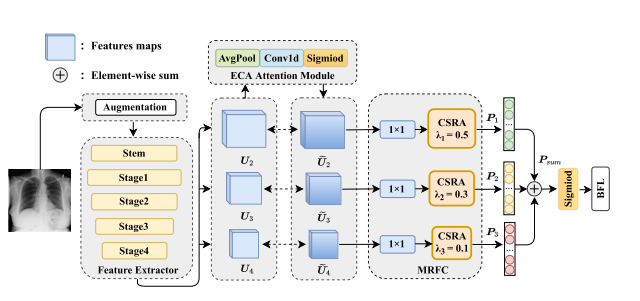

## The Res2Net50 architecture

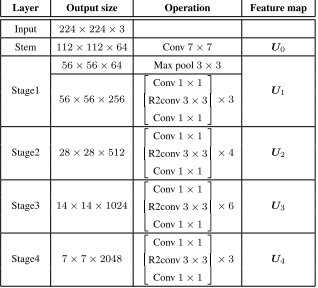


In [ ]:
!git clone https://github.com/fupiao1998/res2net-keras.git

In [ ]:
%cd res2net-keras
import res2net

In [ ]:
# This was taken from the github repo
def slice_layer(slice_num, channel):
    def layer(x):
        slice_channel = channel // slice_num
        slice_list = tf.keras.layers.Lambda(
            lambda t: tf.split(t, num_or_size_splits=slice_num, axis=-1)
        )(x)
        return slice_list
    return layer

In [ ]:
# This was taken from the github repo and adjusted to fit strides in it
def res2net_block(num_filters, slice_num, strides=(1, 1)):
    def layer(input_tensor):
        short_cut = input_tensor

        if strides != (1, 1) or K.int_shape(short_cut)[-1] != num_filters:
            short_cut = Conv2D(num_filters, kernel_size=(1, 1), strides=strides, padding='valid', kernel_initializer='he_normal')(short_cut)
            short_cut = BatchNormalization()(short_cut)
        
        x = res2net.Conv_bn_relu(num_filters=num_filters, kernel_size=(1, 1), strides=strides)(input_tensor)
        slice_list = slice_layer(slice_num, K.int_shape(x)[-1])(x)
        side = res2net.Conv_bn_relu(num_filters=num_filters // slice_num, kernel_size=(3, 3))(slice_list[1])
        z = Concatenate()([slice_list[0], side])  # First and second stage
        
        for i in range(2, slice_num):
            y = res2net.Conv_bn_relu(num_filters=num_filters // slice_num, kernel_size=(3, 3))(Add()([side, slice_list[i]]))
            side = y
            z = Concatenate()([z, y])
        z = res2net.Conv_bn_relu(num_filters=num_filters, kernel_size=(1, 1))(z)
        z = ECA_Module()(z)
        out = Add()([z, short_cut])
        out = Activation('relu')(out)
        return out
    return layer

In [ ]:
def res2net50(input_shape=(256,256,1), include_top=True, num_classes=1000):
    inputs = Input(shape=input_shape)
    

    x = res2net.Conv_bn_relu(64, (7,7), strides=(2,2))(inputs)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)  # Stem
    U0 = x
    x = res2net_block(256, 4)(x) # Stage 1
    U1 = x
    x = res2net_block(512, 8, strides=(2,2))(x) # Stage 2
    U2 = x
    x = res2net_block(1024, 8, strides=(2,2))(x) # Stage 3
    U3 = x
    x = res2net_block(2048, 8, strides=(2,2))(x) # Stage 4
    U4 = x
    
    if include_top:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
        model = tf.keras.models.Model(inputs=inputs, outputs=x)
    else:
        model = tf.keras.models.Model(inputs=inputs, outputs=[U1, U2, U3, U4])
    
    return model

## Then we create the ECA attention module

### The ECA attention transformation is defined as: $\widetilde{U} = U \odot \sigma\left(\text{Conv1D}_k\left(\text{GAP}(U)\right)\right), \quad \widetilde{U} \in \mathbb{R}^{H \times W \times C}$

In [ ]:
def ECA_Module(kernel_size=None, gamma=2, b=1):

    def layer(input_tensor):
        channel = K.int_shape(input_tensor)[-1]
        
        x = GlobalAveragePooling2D()(input_tensor)
        x = Reshape((1, 1, channel))(x)
        
        t = int(abs((math.log(channel, 2) + b) / gamma))
        kernel_size = t if t % 2 else t + 1
        
        x = Conv2D(1, (kernel_size, 1), padding='same',use_bias=False,kernel_initializer='he_normal')(x)
        attention = Activation('sigmoid')(x)
        output = Multiply()([input_tensor, attention])
        return output
        
    return layer


In [ ]:
def MLRFNet(input_shape=(256,256,1), num_classes=14):
    inputs = Input(shape=input_shape)

    # res2net50 block
    base_model = res2net50(input_shape=input_shape, include_top=False, num_classes=num_classes)
    feature_maps = base_model(inputs)
    
    feature_maps = feature_maps[1:]
    
    # Multi-Level Residual Feature Fusion (MRFC)
    channel_reduced = 256 
    lambda_weights = [0.5, 0.3, 0.1]  # CSRA weights
    target_size = K.int_shape(feature_maps[0])[1:3]
    fused_features = []

    for i, fmap in enumerate(feature_maps):
        x = res2net.Conv_bn_relu(channel_reduced, (1, 1))(fmap)
        if K.int_shape(x)[1:3] != target_size:
            x = tf.keras.layers.UpSampling2D(size=(target_size[0] // K.int_shape(x)[1], target_size[1] // K.int_shape(x)[2]))(x)
        fused_features.append(x)
    
    P_sum = fused_features[0]
    for i in range(1, len(fused_features)):
        P_sum = tf.keras.layers.Add()([P_sum, fused_features[i]])
    
    x = GlobalAveragePooling2D()(P_sum) 
    x = Reshape((1, channel_reduced))(x)
    x = Conv1D(filters=num_classes, kernel_size=1, padding='valid', kernel_initializer='he_normal')(x)
    x = Reshape((num_classes,))(x)
    outputs = Activation('sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = MLRFNet(input_shape=(256,256, 1), num_classes=15)
model.summary()

## Now the biased focal loss (BFL):

### Biased Focal Loss (BFL)

**1. Biased Focal Loss:**
$$
\text{BFL} = -\alpha\left(1-\hat{P}_{\text{sum}}\right)^{\beta}\mathbf{y}\log \hat{P}_{\text{sum}} \\
-(1-\alpha)(\hat{P}^{\delta}_{\text{sum}})^{\beta}\left(1-\mathbf{y}\right)\log\left(1-\hat{P}_{\text{sum}}\right)
$$

**2. Probability Shift:**
$$
\hat{P}^{\delta}_{\text{sum}} = \max(\hat{P}_{\text{sum}} - s, 0)
$$

**Where:**
- $\hat{P}_{\text{sum}}$: Sigmoid-normalized prediction  
- $\mathbf{y}$: One-hot label vector ($y_i \in \{0,1\}$)  
- $\alpha=0.4$: Negative sample weight  
- $\beta$: Focusing parameter ($\beta > 0$)  
- $s=0.2$: Probability shift threshold  
- $\widetilde{U}$: ECA-enhanced features  
- $\odot$: Hadamard product  
- $\text{GAP}$: Global Average Pooling

In [94]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[AUC()]) 

In [95]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_auc',
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=10,
        mode='max',
        restore_best_weights=True
    )
]

In [96]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 133s 587ms/step - auc_1: 0.5733 - loss: 0.3935 - val_auc_1: 0.5606 - val_loss: 0.3574 - learning_rate: 0.0010
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 33s 282ms/step - auc_1: 0.6602 - loss: 0.3093 - val_auc_1: 0.5430 - val_loss: 0.3560 - learning_rate: 0.0010
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 33s 279ms/step - auc_1: 0.6848 - loss: 0.3011 - val_auc_1: 0.5708 - val_loss: 0.3492 - learning_rate: 0.0010
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - auc_1: 0.6877 - loss: 0.2963 - val_auc_1: 0.6142 - val_loss: 0.3408 - learning_rate: 0.0010
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - auc_1: 0.6967 - loss: 0.2987 - val_auc_1: 0.5658 - val_loss: 0.4609 - learning_rate: 0.0010
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 33s 283ms/step - auc_1: 0.7017 - loss: 0.2957 - val_auc_1: 0.6784 - val_loss: 0.3295 - learning_rate: 0.0010
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - auc_1: 0.7137 - loss: 0.2938 - val_auc_1: 0.5833

In [98]:
test_predictions = model.predict(test_generator, verbose=1)
print("Test predictions shape:", test_predictions.shape)
test_labels = test_df[disease_columns].values
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(test_labels, test_predictions, average='macro')
print(f"Test AUC: {test_auc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
Test predictions shape: (1020, 15)
Test AUC: 0.4984


In [ ]:
!pip install lime

import lime
from lime import lime_image

Model prediction for selected image: [0.066 0.05  0.083 0.146 0.063 0.423 0.166 0.098 0.166 0.162 0.021 0.102
 0.098 0.193 0.313]
Top 3 predicted labels: ['Emphysema', 'Pneumothorax', 'Pneumonia']
Generating LIME explanation for Emphysema...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanation for Pneumothorax...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanation for Pneumonia...


  0%|          | 0/1000 [00:00<?, ?it/s]

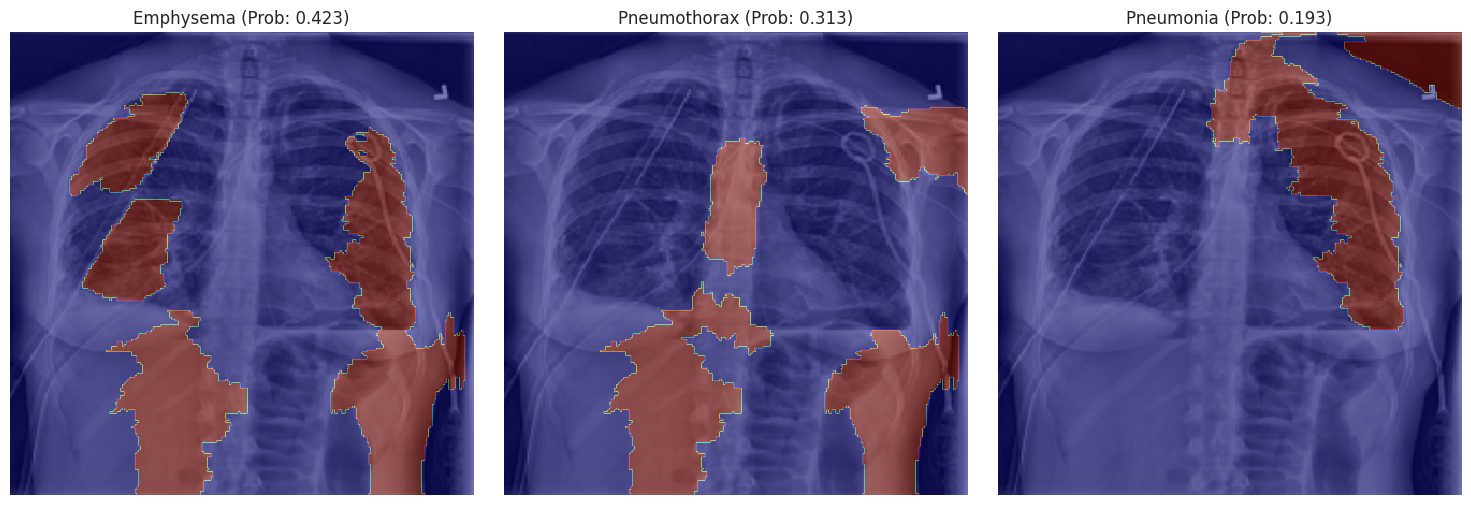

In [114]:
test_images, test_labels_batch = next(iter(test_generator))
image_idx = 0
image_to_explain = test_images[image_idx]
true_label = test_labels_batch[image_idx]

image_to_explain_rgb = np.repeat(image_to_explain, 3, axis=-1)

def predict_fn(images):
    images_gray = np.mean(images, axis=-1, keepdims=True) 
    images_gray = np.clip(images_gray, 0, 1)
    preds = model.predict(images_gray, verbose=0)
    return preds

explainer = lime_image.LimeImageExplainer()

prediction = predict_fn(np.expand_dims(image_to_explain_rgb, axis=0))[0]
print("Model prediction for selected image:", prediction.round(3))

top_labels = np.argsort(prediction)[-3:][::-1] 
print("Top 3 predicted labels:", [disease_columns[i] for i in top_labels])

plt.figure(figsize=(15, 5))
for i, label_idx in enumerate(top_labels):
    print(f"Generating LIME explanation for {disease_columns[label_idx]}...")
    explanation = explainer.explain_instance(
        image_to_explain_rgb,
        predict_fn,
        labels=[label_idx],
        num_samples=1000,
        random_seed=42
    )
    
    temp, mask = explanation.get_image_and_mask(
        label_idx,
        positive_only=True,
        num_features=5,
        hide_rest=True
    )
    
    plt.subplot(1, 3, i+1)
    plt.imshow(image_to_explain_rgb)
    plt.imshow(mask, cmap='jet', alpha=0.5)
    plt.title(f"{disease_columns[label_idx]} (Prob: {prediction[label_idx]:.3f})")
    plt.axis('off')

plt.tight_layout()
plt.show()